In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

C:\Users\pulzara\AppData\Local\Temp\ipykernel_13836\495279268.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from fbprophet import Prophet
from neuralprophet import NeuralProphet 

import random
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
import math 
import random
import miceforest as mf
import sys 
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from fbprophet import Prophet
from neuralprophet import NeuralProphet 

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)


import gc

In [3]:
df_imputed = pd.read_table('C:/Users/pulzara/Documents/Universidad internacional de valencia/TFM/base de datos/SIMAC organizados/BD2/data_imputed_rf.txt',delimiter = '|') 

In [4]:
data = pd.read_table('C:/Users/pulzara/Documents/Universidad internacional de valencia/TFM/base de datos/SIMAC organizados/BD2/data.txt',delimiter = '|') 

In [5]:
data = data[["Fecha","Hora","Temperatura","Velocidad","Presion","Humedad","Precipitacion","Radiacion", "Estacion"]]
data.head(3) 

,Fecha,Hora,Temperatura,Velocidad,Presion,Humedad,Precipitacion,Radiacion,Estacion
0,2017-01-01,0:00:53,18.06,1.79,603.13,84.0,35.8,0.0,alcazares
1,2017-01-01,0:06:00,18.06,2.24,603.16,84.0,35.8,0.0,alcazares
2,2017-01-01,0:11:05,18.06,0.89,603.16,84.0,35.8,0.0,alcazares


In [7]:
df_imputed = df_imputed.drop(df_imputed.columns[[0,1,8]], axis = 1) 

In [8]:
data["Hora"] = pd.to_datetime(data["Fecha"] + ' '+ data["Hora"])  

In [9]:
df_imputed.insert(loc =0,column='Fecha', value = data.Fecha)     
df_imputed.insert(loc =7,column='Estacion', value = data.Estacion) 
df_imputed.insert(loc =7,column='Hora', value = data.Hora) 

In [10]:
df_imputed = df_imputed.drop(df_imputed.columns[[9,10,11]], axis = 1)

In [11]:
df_imputed["Velocidad"] = np.where((df_imputed.Velocidad < 0), 0, df_imputed["Velocidad"])  

In [12]:
def group(data, column_name, frec):

        """
        Esta funcion agrupa por serie de tiempo en dias para obtener la media los datos
        """
        data = data.groupby([pd.Grouper(key=column_name, freq=frec)]).mean() 
        data = data.reset_index()
        data[column_name] = pd.to_datetime(data[column_name]) 
        data[column_name] = data[column_name].sort_values(ascending=False)
        data = data.set_index(column_name)

        return data

In [14]:
df = df_imputed.copy() 

In [15]:
df["Hora"] = df["Hora"].astype(str).str[:-2]   
df["Hora"] = df["Hora"] + '00'

In [16]:
df["Hora"] = pd.to_datetime(df["Hora"]) 

In [17]:
tipos = df.Estacion.unique()
tipos 

array(['alcazares', 'aranjuez', 'bosques_del_norte', 'chec_uribe',
       'el_carmen', 'emas', 'hospital_caldas', 'la_nubia', 'la_palma',
       'milan', 'obs_vulcanologico', 'posgrados', 'yarumos'], dtype=object)

In [19]:
holidays = pd.DataFrame({
                'holiday': 'eventosmanizales', 
                'ds': pd.to_datetime(['2017-04-19','2011-04-13','2011-11-05']),
                'lower_window': 0,
                'upper_window': 1,
            })
holidays

,holiday,ds,lower_window,upper_window
0,eventosmanizales,2017-04-19,0,1
1,eventosmanizales,2011-04-13,0,1
2,eventosmanizales,2011-11-05,0,1


Estacion : alcazares
Precipitacion inferior a 200 - No Hay Peligro


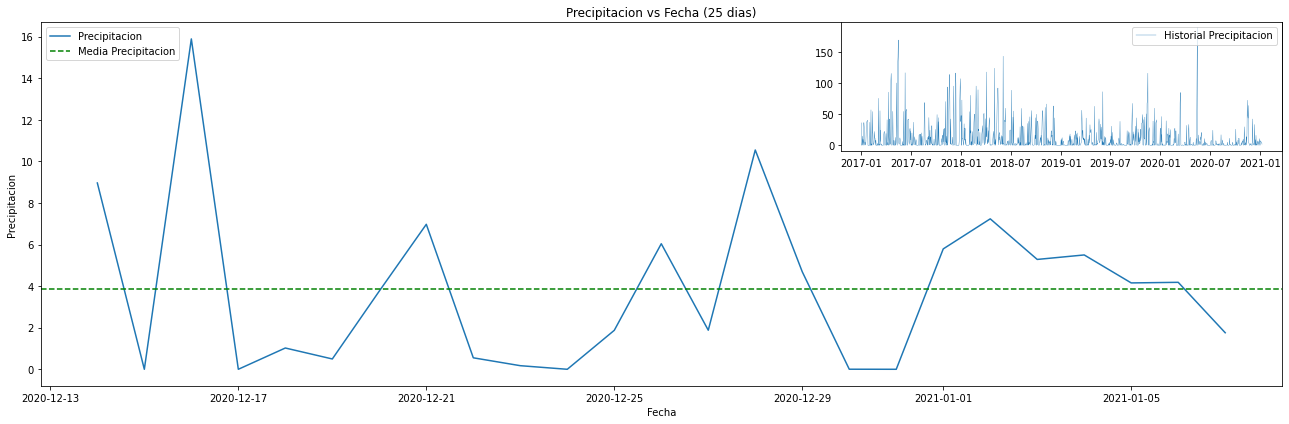

Estacion : aranjuez
Alerta Amarilla


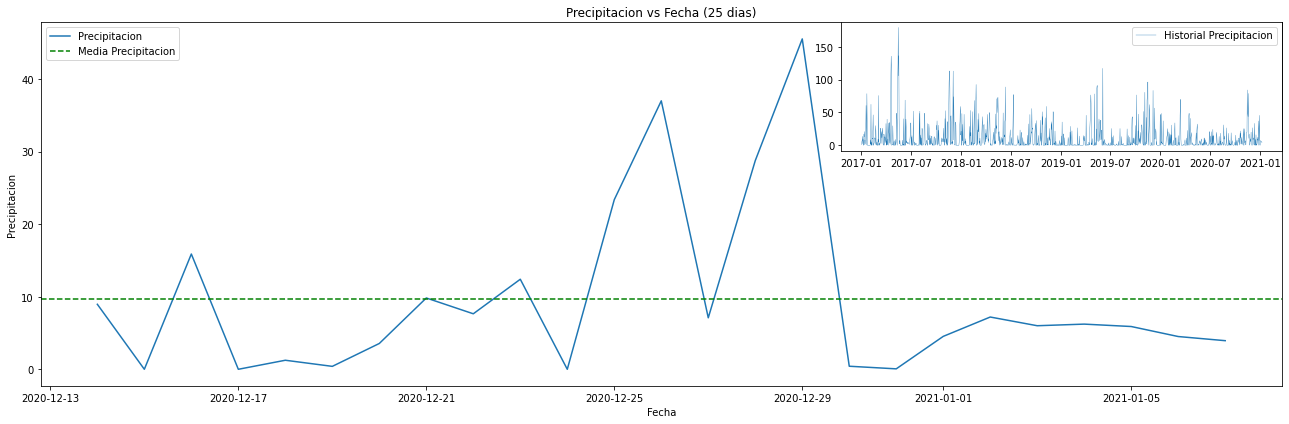

Estacion : bosques_del_norte
Alerta Amarilla


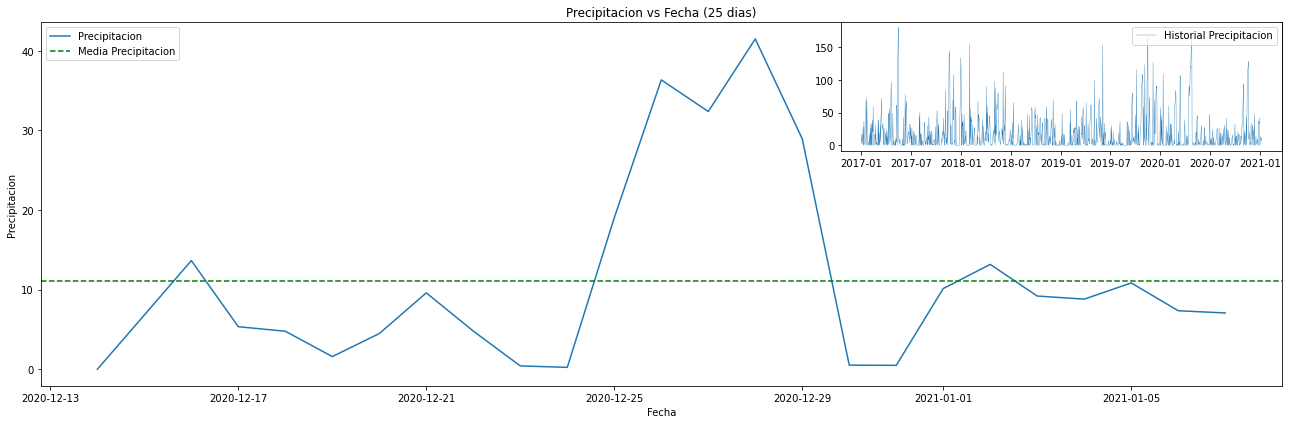

Estacion : chec_uribe
Alerta Roja


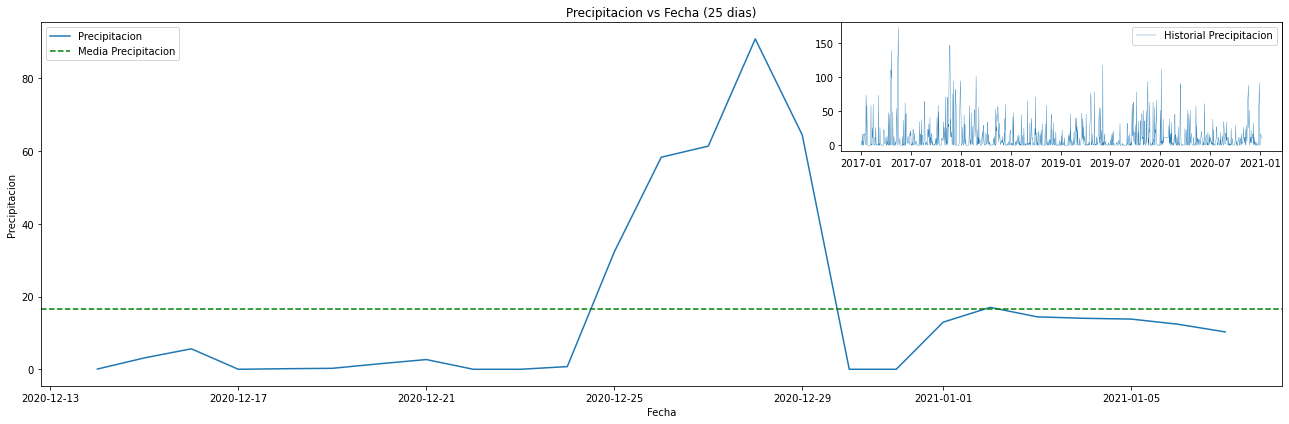

Estacion : el_carmen
Alerta Amarilla


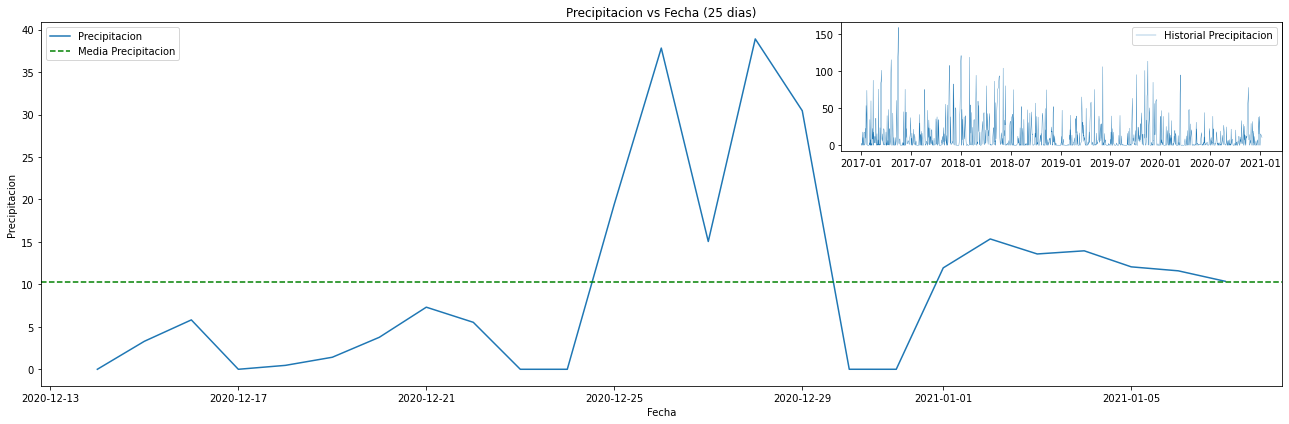

Estacion : emas
Precipitacion inferior a 200 - No Hay Peligro


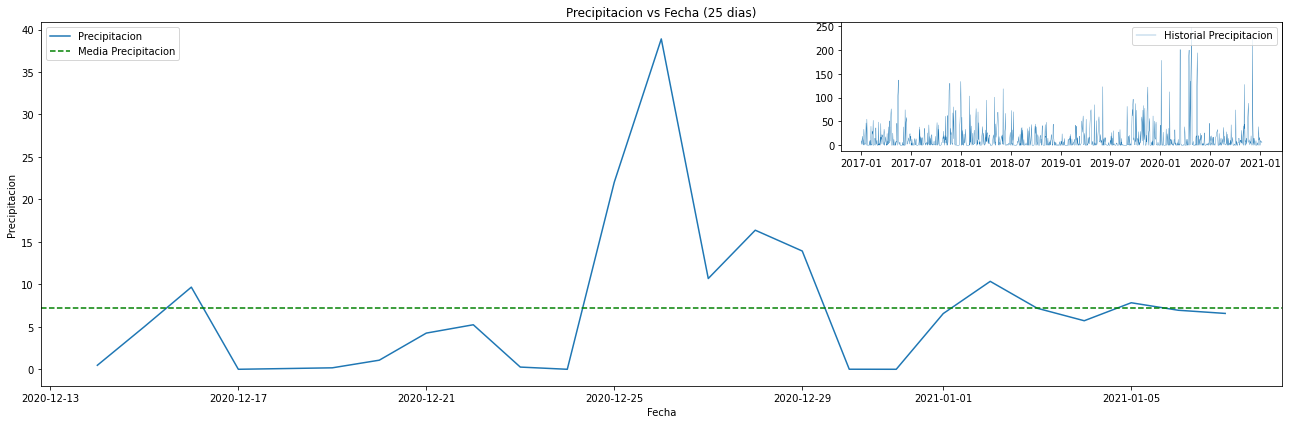

Estacion : hospital_caldas
Alerta Naranja


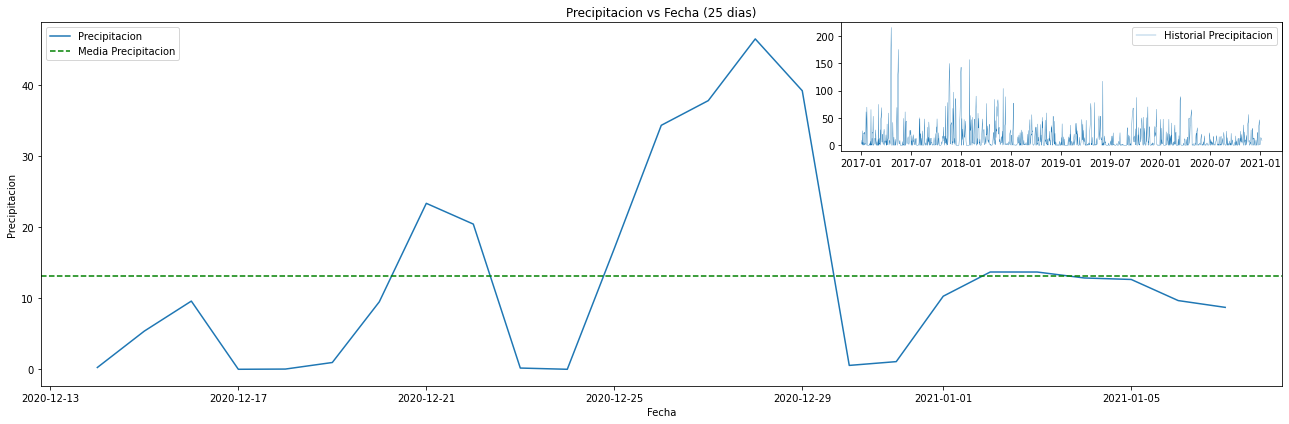

Estacion : la_nubia
Alerta Amarilla


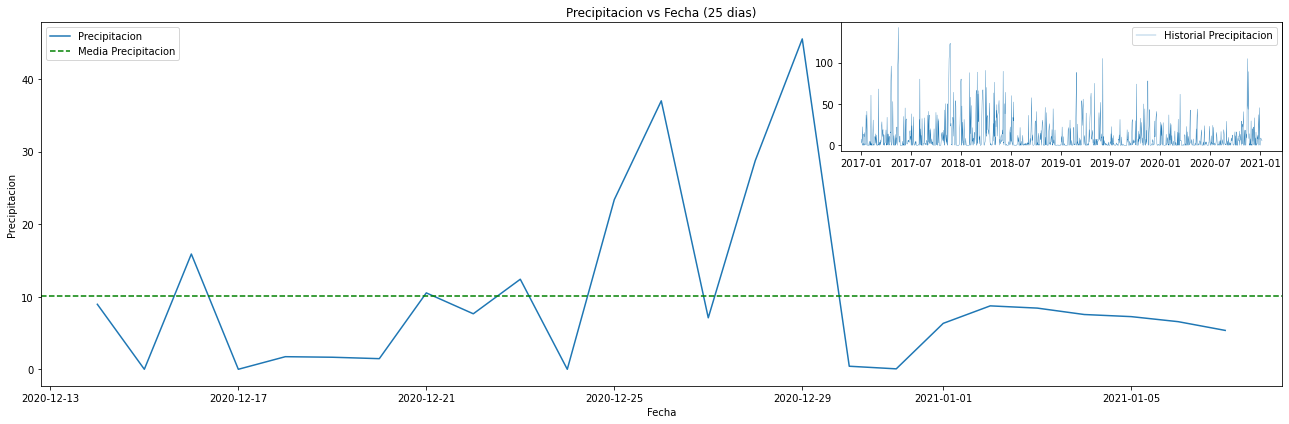

Estacion : la_palma
Alerta Naranja


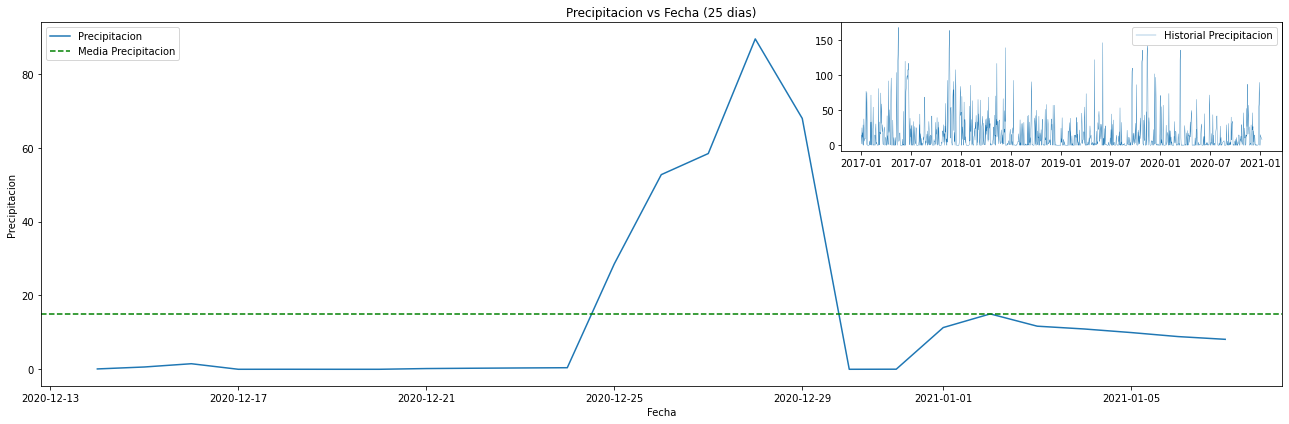

Estacion : milan
Alerta Naranja


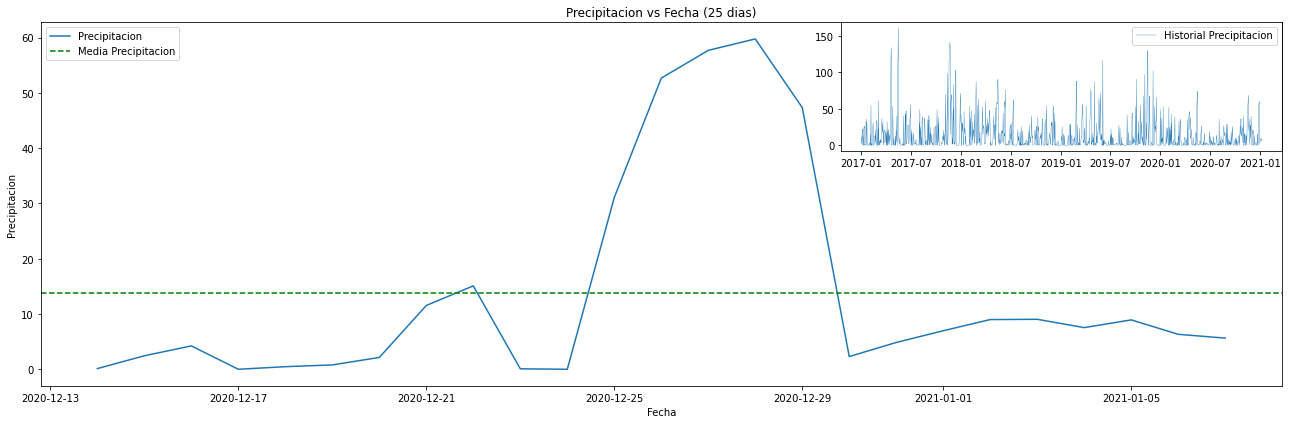

Estacion : obs_vulcanologico
Alerta Naranja


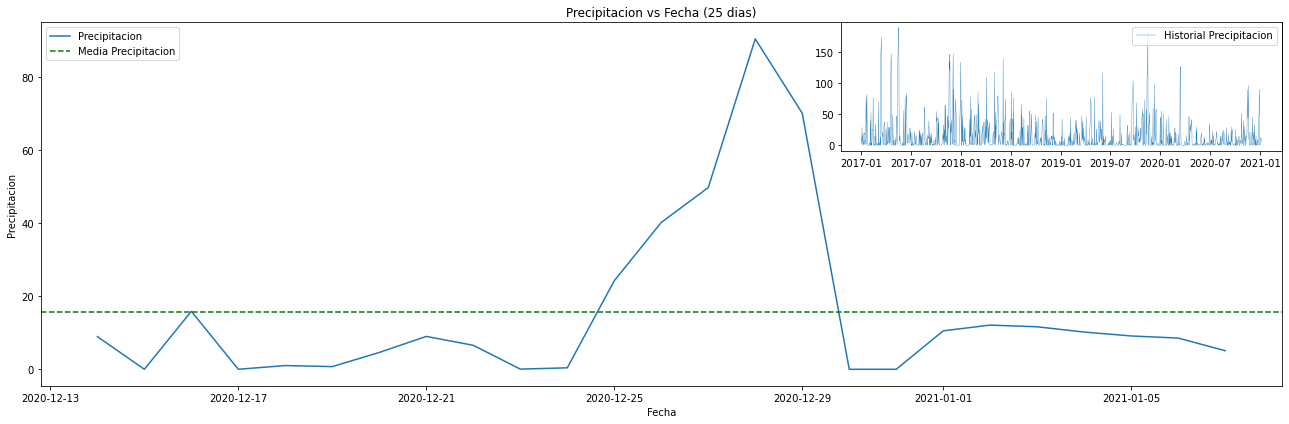

Estacion : posgrados
Alerta Naranja


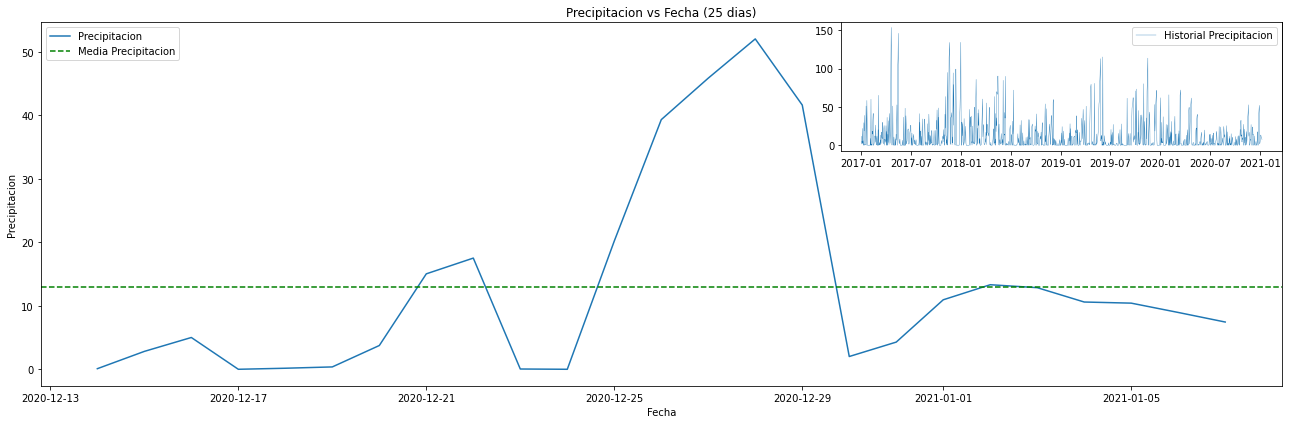

Estacion : yarumos
Alerta Naranja


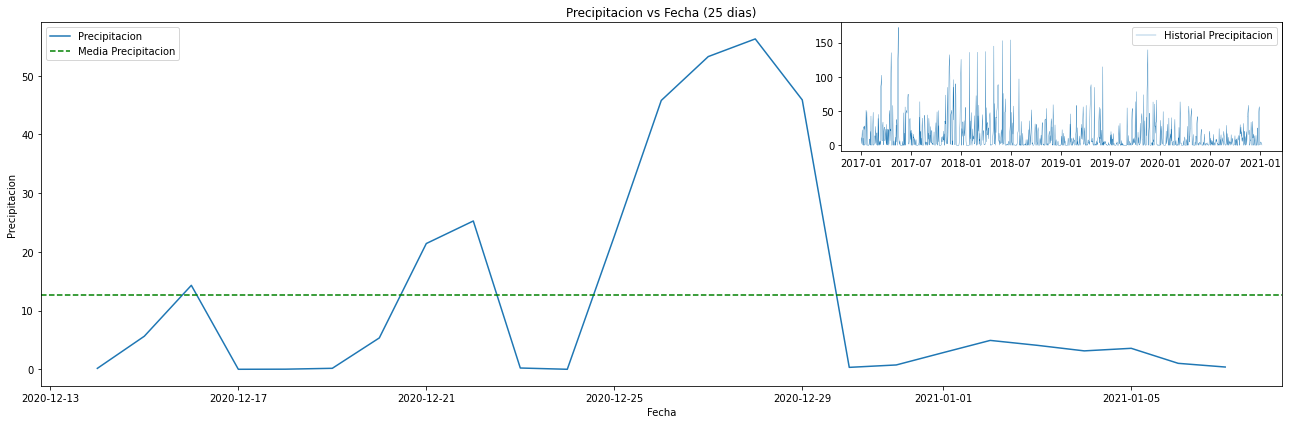

In [277]:
import datetime 
for i in tipos:
    print("Estacion :", i)
    df_1 = df[df.Estacion == i] 
    df_1 = group(df_1,"Hora", frec="1D")
    df_1["Estacion"] = i
    #Rellenamos los valores nulls con la media
    df_1 = df_1.fillna(df_1.mean()) 

    df2 = df_1[["Precipitacion","Temperatura", 'Velocidad','Presion','Humedad','Radiacion']]  
    df2.reset_index(drop = False, inplace = True)
    df2 = df2.rename(columns={"Precipitacion":"y", "Hora": "ds"})
    
    
    m = Prophet(interval_width=0.95, daily_seasonality=True, holidays = holidays) 
    m.add_regressor('Temperatura')
    m.add_regressor('Presion') 
    m.add_regressor('Velocidad')
    m.add_regressor('Humedad')
    m.add_regressor('Radiacion')
    m.fit(df2) 
    
    futur = m.make_future_dataframe(periods=7, freq="1D") 
    future_train = futur.iloc[:-14] 
    future  = futur.iloc[-31:]   
    
    future_train.reset_index(inplace = True, drop = True)
    future.reset_index(inplace = True, drop = True)
    
    future_train = pd.merge(future_train ,df2[["Temperatura", 'Velocidad','Presion','Humedad','Radiacion',"ds"]].iloc[:-7], how = "left", on = ['ds'])
    future_train = future_train.fillna(df_1.mean()) 
    
    
    future = pd.merge(future,df2[["Temperatura", 'Velocidad','Presion','Humedad','Radiacion',"ds"]].iloc[-24:], how = "left", on = ['ds'])
    future = future.fillna(df_1.mean()) 
    
    
    forecast_train = m.predict(future_train) 
    forecast = m.predict(future)
    
    
    forecast2 = forecast.copy()
    forecast2.rename(columns={'yhat':'y'},inplace = True) 

    frames = [df2, forecast2[['ds','y','Temperatura','Velocidad','Presion','Humedad','Radiacion']].iloc[-7:]] 
    final = pd.concat(frames).reset_index(drop = True)

    riesgo = final.y.tail(25).sum()  
    riesgo 

    if riesgo < 200:
        print("Precipitacion inferior a 200 - No Hay Peligro") 

    if (riesgo  >= 200) and (riesgo < 300): 
        print("Alerta Amarilla") 

    elif (riesgo < 400) and (riesgo >= 300):
        print("Alerta Naranja")

    elif riesgo >=400:   
        print("Alerta Roja")


    plt.rcParams["figure.figsize"] = [18, 6] 
    plt.rcParams["figure.autolayout"] = True

    fig, ax1 = plt.subplots()

    left, bottom, width, height = [0.652, 0.64, 0.34, 0.3] 
    ax2 = fig.add_axes([left, bottom, width, height])

    ax2.plot(final.ds, final.y, linewidth=0.34)    
    ax2.legend(['Historial Precipitacion'], loc = "upper right") 

    ax1.plot(final.ds.iloc[-25:], final.y.iloc[-25:])  
    ax1.set_ylabel('Precipitacion') 
    ax1.set_xlabel('Fecha') 
    ax1.axhline(final.y.iloc[-25:].mean(), linestyle = "--", color = "green",label = "Media Precipitacion" )    
    ax1.legend(['Precipitacion','Media Precipitacion'], loc = "upper left")       
    ax1.set_title('Precipitacion vs Fecha (25 dias)') 


    plt.show()
